In [2]:
import robust_regression.sweeps.alpha_sweeps as alsw
import matplotlib.pyplot as plt
import robust_regression.regression_numerics.data_generation as dg
import robust_regression.aux_functions.prior_regularization_funcs as priors
import robust_regression.aux_functions.likelihood_channel_functions as like
import robust_regression.regression_numerics.amp_funcs as amp
import robust_regression.regression_numerics.erm_solvers as erm
from robust_regression.utils.errors import ConvergenceError
from tqdm.auto import tqdm
from robust_regression.fixed_point_equations.fpe_L2_loss import (
    var_hat_func_L2_decorrelated_noise,
)
from robust_regression.fixed_point_equations.fpe_BO import var_func_BO, var_hat_func_BO_num_decorrelated_noise
from robust_regression.fixed_point_equations.fpe_L1_loss import (
    var_hat_func_L1_decorrelated_noise,
)
from robust_regression.fixed_point_equations.fpe_Huber_loss import (
    var_hat_func_Huber_decorrelated_noise,
)
from robust_regression.fixed_point_equations.fpe_L2_regularization import var_func_L2
from robust_regression.aux_functions.misc import estimation_error
import numpy as np

In [3]:
def sigma_order_param(m, q, sigma):
    return sigma


def q_order_param(m, q, sigma):
    return q


def m_order_param(m, q, sigma):
    return m

## Theory Simulations

In [13]:
delta_in, delta_out, percentage, beta = 1.0, 5.0, 0.3, 0.0
alpha_min, alpha_max, n_alpha_pts = 0.1, 1000, 200
n_alpha_pts_BO = 12
delta_eff = (1 - percentage) * delta_in + percentage * delta_out
plateau_alpha_inf = (1 - percentage) * percentage**2 * (1 - beta) ** 2 + percentage * (1 - percentage) ** 2 * (
    beta - 1
) ** 2

In [14]:

(
    alphas_L2,
    f_min_vals_L2,
    reg_param_opt_L2,
    (sigmas_L2, qs_L2, ms_L2),
) = alsw.sweep_alpha_optimal_lambda_fixed_point(
    var_func_L2,
    var_hat_func_L2_decorrelated_noise,
    alpha_min,
    alpha_max,
    n_alpha_pts,
    3.0,
    {"reg_param": 3.0},
    {
        "delta_in": delta_in,
        "delta_out": delta_out,
        "percentage": percentage,
        "beta": beta,
    },
    initial_cond_fpe=(0.6, 0.01, 0.9),
    f_min=estimation_error,
    f_min_args={},
    funs=[sigma_order_param, q_order_param, m_order_param],
    funs_args=[{}, {}, {}],
    min_reg_param=1e-5, 
)

print("L2 done")

(
    alphas_L1,
    f_min_vals_L1,
    reg_param_opt_L1,
    (sigmas_L1, qs_L1, ms_L1),
) = alsw.sweep_alpha_optimal_lambda_fixed_point(
    var_func_L2,
    var_hat_func_L1_decorrelated_noise,
    alpha_min,
    alpha_max,
    n_alpha_pts,
    3.0,
    {"reg_param": 3.0},
    {
        "delta_in": delta_in,
        "delta_out": delta_out,
        "percentage": percentage,
        "beta": beta,
    },
    initial_cond_fpe=(0.6, 0.01, 0.9),
    f_min=estimation_error,
    f_min_args={},
    funs=[sigma_order_param, q_order_param, m_order_param],
    funs_args=[{}, {}, {}],
    min_reg_param=1e-5,
)

print("L1 done")

(
    alphas_Hub,
    f_min_vals_Hub,
    (reg_param_opt_Hub, hub_params_opt_Hub),
    (sigmas_Hub, qs_Hub, ms_Hub),
) = alsw.sweep_alpha_optimal_lambda_hub_param_fixed_point(
    var_func_L2,
    var_hat_func_Huber_decorrelated_noise,
    alpha_min,
    alpha_max,
    n_alpha_pts,
    [3.0, 0.5],
    {"reg_param": 3.0},
    {
        "delta_in": delta_in,
        "delta_out": delta_out,
        "percentage": percentage,
        "beta": beta,
        "a": 1.0,
    },
    initial_cond_fpe=(0.6, 0.01, 0.9),
    f_min=estimation_error,
    f_min_args={},
    funs=[sigma_order_param, q_order_param, m_order_param],
    funs_args=[{}, {}, {}],
    min_reg_param=1e-5,
)

print("Huber done")

alphas_BO, (gen_error_BO_old, qs_BO) = alsw.sweep_alpha_fixed_point(
    var_func_BO,
    var_hat_func_BO_num_decorrelated_noise,
    alpha_min,
    alpha_max,
    n_alpha_pts_BO,
    {"reg_param": 1e-5},
    {
        "delta_in": delta_in,
        "delta_out": delta_out,
        "percentage": percentage,
        "beta": beta,
    },
    initial_cond_fpe=(0.6, 0.01, 0.9),
    funs=[estimation_error, q_order_param],
    funs_args=[{}, {}],
    decreasing=False,
)

print("BO done")

L2 done
L1 done
Huber done
BO done


## Numerical Experiments

In [15]:
d = 300
repetitions = 100

end = 7
skip = 15

print("alphas expample\n", alphas_L2[::skip][1:-end])

alphas expample
 [0.20022004 0.40088063 0.80264335 1.60705282 3.21764175 6.44236351]


In [16]:
alpha_list_sim_L2 = alphas_L2[::skip][1:-end]
lambd_list_L2 = reg_param_opt_L2[::skip][1:-end]

L2_estim_error_sim_mean = np.zeros(len(alpha_list_sim_L2))
L2_estim_error_sim_std = np.zeros(len(alpha_list_sim_L2))


for i, (alpha, lambd) in enumerate(zip(tqdm(alpha_list_sim_L2), lambd_list_L2)):
    all_gen_errors = np.empty((repetitions,))
    for idx in range(repetitions):
        xs, ys, xs_test, ys_test, ground_truth_theta = dg.data_generation(
            dg.measure_gen_decorrelated,
            n_features=d,
            n_samples=max(int(np.around(d * alpha)), 1),
            n_generalization=d,
            measure_fun_args=(delta_in, delta_out, percentage, beta),
        )

        estimated_theta = erm.find_coefficients_L2(ys, xs, lambd)

        all_gen_errors[idx] = np.mean((ground_truth_theta - estimated_theta) ** 2)

        del xs, ys, xs_test, ys_test, ground_truth_theta, estimated_theta

    L2_estim_error_sim_mean[i], L2_estim_error_sim_std[i] = np.mean(all_gen_errors), np.std(all_gen_errors) / np.sqrt(
        repetitions
    )

print(alpha_list_sim_L2, L2_estim_error_sim_mean)
print("L2 sim done")

  0%|          | 0/6 [00:00<?, ?it/s]

[0.20022004 0.40088063 0.80264335 1.60705282 3.21764175 6.44236351] [0.96887707 0.92223074 0.89091666 0.77735725 0.63728457 0.46221705]
L2 sim done


In [21]:
alpha_list_sim_Hub = alphas_Hub[::skip][1:-end]
a_list_Hub = hub_params_opt_Hub[::skip][1:-end]
lambd_list_Hub = reg_param_opt_Hub[::skip][1:-end]

Huber_estim_error_sim_mean = np.zeros(len(alpha_list_sim_Hub))
Huber_estim_error_sim_std = np.zeros(len(alpha_list_sim_Hub))


for i, (alpha, lambd, a) in enumerate(zip(tqdm(alpha_list_sim_Hub), lambd_list_Hub, a_list_Hub)):
    all_gen_errors = np.empty((repetitions,))
    for idx in range(repetitions):
        xs, ys, xs_test, ys_test, ground_truth_theta = dg.data_generation(
            dg.measure_gen_decorrelated,
            n_features=d,
            n_samples=max(int(np.around(d * alpha)), 1),
            n_generalization=d,
            measure_fun_args=(delta_in, delta_out, percentage, beta),
        )

        estimated_theta = erm.find_coefficients_Huber(ys, xs, lambd, a)

        all_gen_errors[idx] = np.mean((ground_truth_theta - estimated_theta) ** 2)

        del xs, ys, xs_test, ys_test, ground_truth_theta, estimated_theta

    Huber_estim_error_sim_mean[i], Huber_estim_error_sim_std[i] = np.mean(all_gen_errors), np.std(all_gen_errors) / np.sqrt(
        repetitions
    )

print("Huber sim done.")

  0%|          | 0/6 [00:00<?, ?it/s]

Huber sim done.


In [23]:
alpha_list_sim_L1 = alphas_L1[::skip][1:-end]
lambd_list_L1 = reg_param_opt_L1[::skip][1:-end]

a_val_L1 = 1e-3
lambd_list_L1 *= a_val_L1

L1_estim_error_sim_mean = np.zeros(len(alpha_list_sim_L1))
L1_estim_error_sim_std = np.zeros(len(alpha_list_sim_L1))

for i, (alpha, lambd) in enumerate(zip(tqdm(alpha_list_sim_L1), lambd_list_L1)):
    all_gen_errors = np.empty((repetitions,))
    for idx in range(repetitions):
        xs, ys, xs_test, ys_test, ground_truth_theta = dg.data_generation(
            dg.measure_gen_decorrelated,
            n_features=d,
            n_samples=max(int(np.around(d * alpha)), 1),
            n_generalization=d,
            measure_fun_args=(delta_in, delta_out, percentage, beta),
        )

        estimated_theta = erm.find_coefficients_Huber(ys, xs, lambd, a_val_L1)

        all_gen_errors[idx] = np.mean((ground_truth_theta - estimated_theta) ** 2)

        del xs, ys, xs_test, ys_test, ground_truth_theta, estimated_theta

    L1_estim_error_sim_mean[i], L1_estim_error_sim_std[i] = np.mean(all_gen_errors), np.std(all_gen_errors) / np.sqrt(
        repetitions
    )

print("L1 sim done.")

  0%|          | 0/6 [00:00<?, ?it/s]

L1 sim done.


In [26]:
alphas = np.array(
    [
        1.34977233e-01,
        1.82188534e-01,
        2.45913043e-01,
        3.31926620e-01,
        4.48025368e-01,
        6.04732245e-01,
        8.16250851e-01,
        1.10175281e00,
        1.48711546e00,
        2.00726730e00,
        2.70935387e00,
        3.65701088e00,
        4.93613210e00,
        6.66265452e00,
        8.99306672e00,
        1.21385926e01,
        1.63843365e01,
        2.21151240e01,
        2.98503825e01,
        4.02912203e01,
        5.43839743e01,
        7.34059837e01,
        9.90813657e01
    ]
)

means_estim_error = []
stds_estim_error = []

alphas_2 = []

for idx, alpha in enumerate(tqdm(alphas)):
    all_gen_errors = []
    all_estim_errors = []

    for idx in range(repetitions):
        try:
            xs, ys, xs_test, ys_test, ground_truth_theta = dg.data_generation(
                dg.measure_gen_decorrelated,
                n_features=d,
                n_samples=max(int(np.around(d * alpha)), 1),
                n_generalization=2 * d,
                measure_fun_args=(delta_in, delta_out, percentage, beta),
            )

            estimated_theta, _ = amp.GAMP_unsimplified_iters(
                priors.f_w_Bayes_gaussian_prior,
                priors.Df_w_Bayes_gaussian_prior,
                like.f_out_Bayes_decorrelated_noise,
                like.Df_out_Bayes_decorrelated_noise,
                ys,
                xs,
                (0.0, 1.0),
                (delta_in, delta_out, percentage, beta),
                np.random.normal(size=d),
                1.0,
                max_iter=10_000,
                blend=0.85,
            )

            all_gen_errors.append(
                np.mean((ys_test - (1 - percentage + percentage * beta) * xs_test @ estimated_theta / np.sqrt(d)) ** 2)
                - np.mean(
                    (ys_test - (1 - percentage + percentage * beta) * xs_test @ ground_truth_theta / np.sqrt(d)) ** 2
                )
            )

            all_estim_errors.append(np.mean(np.square(estimated_theta - ground_truth_theta)))

            del xs, ys, xs_test, ys_test, ground_truth_theta, estimated_theta

        except ConvergenceError:
            continue

    means_estim_error.append(np.mean(all_estim_errors))
    stds_estim_error.append(np.std(all_estim_errors) / np.sqrt(repetitions))

    alphas_2.append(alpha)
print("GAMP sim done.")

  0%|          | 0/23 [00:00<?, ?it/s]

GAMP sim done.


## Plotting

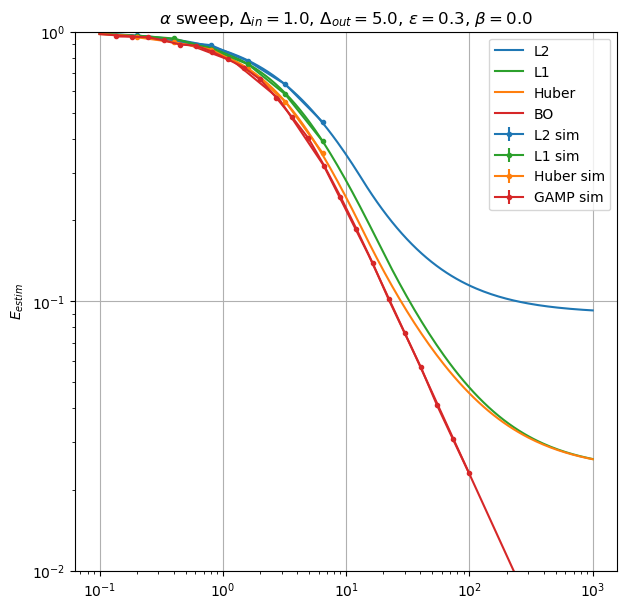

In [27]:
plt.figure(figsize=(7, 7))

plt.title(
    "$\\alpha$ sweep, $\\Delta_{{in}} = {}$, $\\Delta_{{out}} = {}$, $\\epsilon = {}$, $\\beta = {}$".format(
        delta_in, delta_out, percentage, beta
    )
)

plt.plot(alphas_L2, f_min_vals_L2, label="L2", color="tab:blue")
plt.errorbar(
    alpha_list_sim_L2,
    L2_estim_error_sim_mean,
    yerr=L2_estim_error_sim_std,
    label="L2 sim",
    color="tab:blue",
    linestyle=None,
    marker=".",
)
plt.plot(alphas_L1, f_min_vals_L1, label="L1", color="tab:green")
plt.errorbar(
    alpha_list_sim_L1,
    L1_estim_error_sim_mean,
    yerr=L1_estim_error_sim_std,
    label="L1 sim",
    color="tab:green",
    linestyle=None,
    marker=".",
)
plt.plot(alphas_Hub, f_min_vals_Hub, label="Huber", color="tab:orange")
plt.errorbar(
    alpha_list_sim_Hub,
    Huber_estim_error_sim_mean,
    yerr=Huber_estim_error_sim_std,
    label="Huber sim",
    color="tab:orange",
    linestyle=None,
    marker=".",
)
plt.plot(alphas_BO, gen_error_BO_old, label="BO", color="tab:red")
plt.errorbar(
    alphas_2,
    means_estim_error,
    yerr=stds_estim_error,
    label="GAMP sim",
    color="tab:red",
    linestyle=None,
    marker=".",
)

plt.ylim(1e-2, 1e0)
plt.yscale("log")
plt.xscale("log")
plt.ylabel(r"$E_{estim}$")
plt.legend()
plt.grid()

plt.show()